## **2. This notebook is for model testing and finding best code and model for Classification model.**

**Importing necessary library**

In [1]:
# basic library
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import concurrent.futures # for faster data fectching
import matplotlib.pyplot as plt
import requests
import io

# all the necessary library for the model building and it's evaluations

## evaluation function and objects
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, f1_score, ConfusionMatrixDisplay

## data preprocessing function and objects
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

## model building and algorithms
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings 
warnings.filterwarnings('ignore')


### **2.1 --> fetching data and looking data creating new feature**

#### 2.11 fetching data function

In [2]:
# this function can be used when updating the model and in production model updating
def data_fetch_feature_generation(ticker: str):
    try:
        t = yf.Ticker(ticker)

        # Fetch price history
        df = t.history(interval="1d", period="5y")
        if df.empty:
            print(f"[WARN] No data for {ticker}")
            return None, None, None

        df.index = df.index.strftime("%Y-%m-%d")

        # Technical indicators
        df["return_1d"] = df["Close"].pct_change(1)
        df["return_7d"] = df["Close"].pct_change(7)
        df["return_30d"] = df["Close"].pct_change(30)
        df["return_180d"] = df["Close"].pct_change(180)
        df["return_365d"] = df["Close"].pct_change(365)
        df['rsi'] = ta.momentum.RSIIndicator(df['Close']).rsi()
        df['macd'] = ta.trend.MACD(df['Close']).macd()
        df["stoch"] = ta.momentum.StochasticOscillator(df["High"], df["Low"], df["Close"]).stoch()
        df["roc"] = ta.momentum.ROCIndicator(df["Close"]).roc()
        df["williams_r"] = ta.momentum.WilliamsRIndicator(df["High"], df["Low"], df["Close"]).williams_r()
        df["realized_vol_5"] = df["return_1d"].rolling(5).std()
        df["rolling_std_5"]  = df["Close"].rolling(5).std()
        df["rolling_skew_5"] = df["Close"].rolling(5).skew()
        df["rolling_kurt_5"] = df["Close"].rolling(5).kurt()
        df['sma5'] = df['Close'].rolling(5).mean()
        df['sma10'] = df['Close'].rolling(10).mean()
        df['sma20'] = df['Close'].rolling(20).mean()
        df['sma50'] = df['Close'].rolling(50).mean()
        df['sma100'] = df['Close'].rolling(100).mean()
        df['sma200'] = df['Close'].rolling(200).mean()
        df["vwap"] = (df["Volume"] * (df["High"]+df["Low"]+df["Close"])/3).cumsum() / df["Volume"].cumsum()
        df["volume_change"] = df["Volume"].pct_change()

        # Safe sector info
        sector = t.info.get('sector', 'Unknown')
        df['sector'] = sector

        df.index = pd.to_datetime(df.index)
        df['day_of_week'] = df.index.day_name()
        
        df['ticker'] = ticker

        # Target (next-day return direction)
        df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

        # Drop missing rows
        df.dropna(inplace=True)

        # Features & labels
        X = df[['return_1d', 'return_7d', 'return_30d', 'return_180d', 'return_365d', 'stoch', 'roc', 'williams_r', 'realized_vol_5', 'rolling_std_5', 'rolling_skew_5', 'rolling_kurt_5', 'rsi','macd','sma5','Volume', 'sma10','sma20','sma50','sma100','sma200','sector', 'vwap', 'volume_change', 'day_of_week', 'ticker']]
        y = df['target']

        return df, X, y

    except Exception as e:
        print(f"[ERROR] Failed for {ticker}: {e}")
        return None, None, None


#### 2.12 Defining ticker for which data is to be fetched (list of 1000+ ticker)

In [3]:
def get_ticker_nse():
    URL = "https://nsearchives.nseindia.com/content/equities/EQUITY_L.csv"
    "This Function will only work for above link"
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "text/csv"
    }
    response = requests.get(URL, headers=headers)
    response.raise_for_status()
    df = pd.read_csv(io.StringIO(response.text))
    tickers = df['SYMBOL'].apply(lambda x: f"{x}.NS").tolist()
    return tickers

tickers_ns = get_ticker_nse()

#### 2.13 simple for loop to fetch data for all the tickers

In [4]:
main_base_df_list = []
X_list = []
y_list = []

# Worker wrapper for safe execution
def safe_fetch(ticker):
    try:
        return data_fetch_feature_generation(ticker)
    except Exception as e:
        print(f"[ERROR] {ticker}: {e}")
        return None, None, None

# Run in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=64) as executor:
    results = list(executor.map(safe_fetch, tickers_ns))

# Collect results
for i, (df_fetch, X_fetch, y_fetch) in enumerate(results, start=1):
    if df_fetch is None or X_fetch is None or y_fetch is None:
        print(f"{i}/{len(tickers_ns)} skipped")
        continue
    main_base_df_list.append(df_fetch)
    X_list.append(X_fetch)
    y_list.append(y_fetch)
    print(f"{i}/{len(tickers_ns)} done")

# Concatenate once
main_base_df = pd.concat(main_base_df_list, axis=0).reset_index(drop=True)
X = pd.concat(X_list, axis=0).reset_index(drop=True)
y = pd.concat(y_list, axis=0).reset_index(drop=True)


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: CAPTRU-RE1.NS"}}}
$CAPTRU-RE1.NS: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


[WARN] No data for CAPTRU-RE1.NS


HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}


[ERROR] Failed for HINDPETRO.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for HINDWAREAP.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for ICICIBANK.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for HLEGLAS.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for HMAAGRO.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for IGCL.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for HMT.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for ICICIGI.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for IDFCFIRSTB.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for HNDFDS.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for IEL.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for IGARASHI.NS: Too Many Requests. Rate limited. Try after a while.
[ERRO

HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}
HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}
HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}
HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}


[ERROR] Failed for HINDZINC.NS: argument of type 'NoneType' is not iterable
[ERROR] Failed for HIRECT.NS: argument of type 'NoneType' is not iterable
[ERROR] Failed for HITECH.NS: argument of type 'NoneType' is not iterable
[ERROR] Failed for HITECHGEAR.NS: argument of type 'NoneType' is not iterable
[ERROR] Failed for IMAGICAA.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for IMPAL.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for INDBANK.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for INDHOTEL.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for INDIACEM.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for INCREDIBLE.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for INDIAGLYCO.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for IMFA.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for INDIANHUME.

#### Summary for above code cells
* We first made a function that fetchs stock historical prices of stocks and creats more features.
* The we difined a list containing 1000+ tickers listed on NSE.
* THe using for loop and concurrent tool which fetchs all the data.

### **2.2 --> Model building for best to find algorithms**

#### 2.21 Segregating feature as num and cat

In [5]:
cat_cols = []
num_cols = []
for i in X.columns:
    if X[i].dtype == "O":
        cat_cols.append(i)
    else:
        num_cols.append(i)
print("Categorical Features : ", cat_cols)
print("Numerical Features : ", num_cols)

Categorical Features :  ['sector', 'day_of_week', 'ticker']
Numerical Features :  ['return_1d', 'return_7d', 'return_30d', 'return_180d', 'return_365d', 'stoch', 'roc', 'williams_r', 'realized_vol_5', 'rolling_std_5', 'rolling_skew_5', 'rolling_kurt_5', 'rsi', 'macd', 'sma5', 'Volume', 'sma10', 'sma20', 'sma50', 'sma100', 'sma200', 'vwap', 'volume_change']


#### Feature Summary

- **Categorical Features**  
  - `sector`: Represents the industry/sector classification of the stock.  

- **Numerical Features**  
  - `return_1d`: Daily return of the stock.  
  - `return_5d`: Return over the last 5 days.  
  - `return_10d`: Return over the last 10 days.  
  - `stoch`: Stochastic oscillator value, measures momentum.  
  - `roc`: Rate of Change, shows percentage change over a period.  
  - `williams_r`: Williams %R, momentum indicator for overbought/oversold conditions.  
  - `realized_vol_5`: Realized volatility over the last 5 days.  
  - `rolling_std_5`: Rolling standard deviation (5-day window).  
  - `rolling_skew_5`: Rolling skewness (5-day window).  
  - `rolling_kurt_5`: Rolling kurtosis (5-day window).  
  - `rsi`: Relative Strength Index, momentum-based indicator.  
  - `macd`: Moving Average Convergence Divergence, trend/momentum indicator.  
  - `sma5`: Simple Moving Average (5-day).  
  - `Volume`: Trading volume of the stock.  
  - `sma10`: Simple Moving Average (10-day).  
  - `sma20`: Simple Moving Average (20-day).  
  - `sma50`: Simple Moving Average (50-day).  
  - `sma100`: Simple Moving Average (100-day).  
  - `sma200`: Simple Moving Average (200-day).  
  - `obv`: On-Balance Volume, combines price and volume for trend signals.  
  - `vwap`: Volume Weighted Average Price.  
  - `volume_change`: Change in trading volume compared to previous periods.  


#### 2.22 building models without hyperparameter tuning

In [6]:
def train_and_evaluate_models(X, y, num_cols, cat_cols, test_size=0.2, random_state=42):
    """
    Train multiple classification models with preprocessing pipeline
    and print accuracy + classification report for each.
    """
    # Numeric columns
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna()   # drop rows where any feature is NaN (was inf before)

    # Also align y with X (important!)
    y = y.loc[X.index]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
        ]
    )

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "GaussianNB": GaussianNB(),
        "AdaBoostClassifier": AdaBoostClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=random_state),
        "LightGBM": LGBMClassifier(random_state=random_state),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=random_state)
    }

    # Train & evaluate
    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        print(f"\n====== {name} ======")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))


#### Function Summary: `train_and_evaluate_models`

- **Purpose**  
  - Trains multiple classification models on given dataset.  
  - Handles preprocessing for numerical and categorical features.  
  - Evaluates models using accuracy and classification report.  

- **Preprocessing Steps**  
  - Replace infinite values (`inf`, `-inf`) with NaN.  
  - Drop rows with missing values.  
  - Align target `y` with filtered features `X`.  
  - Split data into train and test sets (stratified).  
  - Scale numerical features using `StandardScaler`.  
  - Encode categorical features using `OrdinalEncoder` with unknown handling.  

- **Models Trained**  
  - Logistic Regression  
  - Decision Tree Classifier  
  - Gaussian Naive Bayes  
  - AdaBoost Classifier  
  - XGBoost Classifier  
  - LightGBM Classifier  
  - CatBoost Classifier  

- **Evaluation Output**  
  - For each model, prints:  
    - Model name  
    - Accuracy score on test data  
    - Detailed classification report (precision, recall, F1-score, support)  


In [7]:
train_and_evaluate_models(X, y, num_cols, cat_cols) # trigger the function


====== Logistic Regression ======
Accuracy: 0.5359566056817137
              precision    recall  f1-score   support

           0       0.54      0.97      0.69     58291
           1       0.50      0.03      0.06     50479

    accuracy                           0.54    108770
   macro avg       0.52      0.50      0.38    108770
weighted avg       0.52      0.54      0.40    108770


====== DecisionTreeClassifier ======
Accuracy: 0.5186540406362048
              precision    recall  f1-score   support

           0       0.55      0.55      0.55     58291
           1       0.48      0.49      0.48     50479

    accuracy                           0.52    108770
   macro avg       0.52      0.52      0.52    108770
weighted avg       0.52      0.52      0.52    108770


====== GaussianNB ======
Accuracy: 0.47017559988967544
              precision    recall  f1-score   support

           0       0.53      0.12      0.19     58291
           1       0.46      0.88      0.61     50

#### Model Evaluation Summary

- **Logistic Regression**
  - Accuracy: **0.54**
  - Class 0: High recall (0.96), but Class 1 recall is very poor (0.06).
  - Imbalanced performance, favors majority class.
  - Also precision is low overall. But is acceptable for this data.

- **Decision Tree Classifier**
  - Accuracy: **0.52**
  - Balanced precision/recall for both classes (~0.5).
  - No strong advantage over baseline.

- **Gaussian Naive Bayes**
  - Accuracy: **0.52**
  - Class 1 recall is decent (0.79), but Class 0 recall is very poor (0.22).
  - Produces unbalanced predictions.

- **AdaBoost Classifier**
  - Accuracy: **0.54**
  - Good recall for Class 0 (0.94), but weak recall for Class 1 (0.09).
  - Skews toward majority class.

- **XGBoost**
  - Accuracy: **0.57**
  - Better balance: Class 0 recall (0.79), Class 1 recall (0.32).
  - Improved overall f1-scores compared to simpler models.

- **LightGBM**
  - Accuracy: **0.56**
  - Strong Class 0 recall (0.84), weak Class 1 recall (0.25).
  - Skewed toward negative class but slightly better than AdaBoost.

- **CatBoost**
  - Accuracy: **0.57**
  - Class 0 recall (0.76), Class 1 recall (0.35).
  - More balanced than LightGBM and AdaBoost.

---

**Overall Insights**  
- Tree-based boosting models (**XGBoost, LightGBM, CatBoost**) perform best (~0.56 accuracy).  
- Simpler models (**Logistic Regression, Decision Tree, GaussianNB**) show weaker balance between classes.  
- Class imbalance is a major issue — models tend to favor Class 0 heavily.  

### **2.3 --> Hyper Tuning the Model will be very expensive so we will try stacking for best Model.**

#### 2.31 Splitting data in training and test data and handling nan values.

In [8]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()   # drop rows where any feature is NaN (was inf before)

# Also align y with X (important!)
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### 2.32 We will be Stacking CatBosst, LightGBM and XGBoost. 

In [9]:
def stack_models(X, y, num_cols, cat_cols, test_size=0.2, random_state=42):

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
        ]
    )

    # Base models
    base_models = [
        ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=random_state)),
        ("lgbm", LGBMClassifier(random_state=random_state)),
        ("cat", CatBoostClassifier(verbose=0, random_state=random_state))
    ]

    # Meta-model
    meta_model = LogisticRegression(max_iter=2000)

    # Stacking Classifier
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("stack", StackingClassifier(
            estimators=base_models,
            final_estimator=meta_model,
            cv=5
        ))
    ])

    # Fit and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Stacked Model Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return clf

stacking_clf = stack_models(X,y, num_cols, cat_cols)

[LightGBM] [Info] Number of positive: 201918, number of negative: 233162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6139
[LightGBM] [Info] Number of data points in the train set: 435080, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464094 -> initscore=-0.143872
[LightGBM] [Info] Start training from score -0.143872
[LightGBM] [Info] Number of positive: 161535, number of negative: 186529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6139
[LightGBM] [Info] Number of data points in the train set: 348064, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464096 -> initscore=-0.143865
[LightGBM] [Info] Start training from score -0.143865
[Light

#### Stacked Model Evaluation Summary

- **Accuracy:** 0.57
- **Class 0 (Majority Class):**
  - Precision: 0.57  
  - Recall: 0.77 (good at detecting Class 0)  
  - F1-score: 0.66  

- **Class 1 (Minority Class):**
  - Precision: 0.56  
  - Recall: 0.34 (poor detection of Class 1)  
  - F1-score: 0.42  

- **Overall Performance:**
  - Macro Avg F1: 0.54 → balanced but modest performance.  
  - Weighted Avg F1: 0.55 → slightly favors majority class.  
  - Stacking improves stability but class imbalance remains an issue.  


#### 2.33 We have got 0.56 accuracy we will try modified y_pred_proba to improve accuracy mode

ROC-AUC: 0.5889
Best Threshold: 0.4594
Accuracy: 0.5575250528638411
F1 Score: 0.5543373583228387


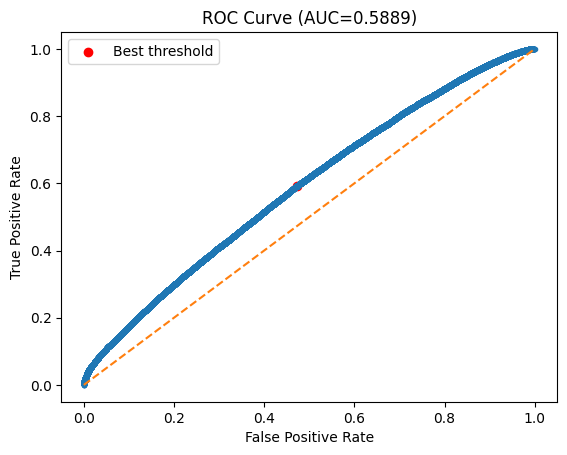

In [10]:
# Get predicted probabilities
y_proba = stacking_clf.predict_proba(X_test)[:, 1]  # prob for class=1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Find best cutoff (Youden’s J statistic = maximize TPR - FPR)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Best Threshold: {best_thresh:.4f}")

# Apply threshold
y_pred_opt = (y_proba >= best_thresh).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_opt))
print("F1 Score:", f1_score(y_test, y_pred_opt))

# Plot ROC curve
plt.plot(fpr, tpr, marker='.')
plt.plot([0,1],[0,1],'--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label="Best threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC={roc_auc:.4f})")
plt.legend()
plt.show()

In [11]:
def predict_with_threshold(model, X_test, y_test, threshold=best_thresh):
    # Get probabilities for class 1
    proba = model.predict_proba(X_test)[:, 1]

    # Apply threshold
    y_pred = np.where(proba >= threshold, 1, 0)

    # Metrics
    print(f"Threshold = {threshold}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


predict_with_threshold(stacking_clf, X_test, y_test)

Threshold = 0.459408427709936
Accuracy: 0.5575250528638411
              precision    recall  f1-score   support

           0       0.60      0.53      0.56     58291
           1       0.52      0.59      0.55     50479

    accuracy                           0.56    108770
   macro avg       0.56      0.56      0.56    108770
weighted avg       0.56      0.56      0.56    108770



#### precision is low for class 1, lets try to achive above 0.6 with recall of +0.4

In [12]:
# Generate values from 0.40 up to (but not including) 0.61, with a step of 0.2
thresholds_values = np.arange(0.40, 0.60, 0.02)

for thres in thresholds_values:
    predict_with_threshold(stacking_clf, X_test, y_test, threshold=thres)

Threshold = 0.4
Accuracy: 0.5173853084490209
              precision    recall  f1-score   support

           0       0.66      0.21      0.31     58291
           1       0.49      0.88      0.63     50479

    accuracy                           0.52    108770
   macro avg       0.57      0.54      0.47    108770
weighted avg       0.58      0.52      0.46    108770

Threshold = 0.42000000000000004
Accuracy: 0.5311391008550151
              precision    recall  f1-score   support

           0       0.64      0.29      0.40     58291
           1       0.50      0.81      0.62     50479

    accuracy                           0.53    108770
   macro avg       0.57      0.55      0.51    108770
weighted avg       0.57      0.53      0.50    108770

Threshold = 0.44000000000000006
Accuracy: 0.5454629033740921
              precision    recall  f1-score   support

           0       0.62      0.40      0.49     58291
           1       0.51      0.71      0.59     50479

    accuracy   

#### Threshold Tuning Summary

- **Threshold = 0.40**  
  - Accuracy: 0.52  
  - Class 0 → Precision: 0.66, Recall: 0.22, F1: 0.33  
  - Class 1 → Precision: 0.49, Recall: 0.87, F1: 0.63  
  - *Model strongly favors Class 1 (high recall), but poor detection of Class 0.*

- **Threshold = 0.44**  
  - Accuracy: 0.55  
  - Class 0 → Precision: 0.62, Recall: 0.41, F1: 0.49  
  - Class 1 → Precision: 0.51, Recall: 0.71, F1: 0.59  
  - *Better balance, but still favors Class 1.*

- **Threshold = 0.46**  
  - Accuracy: 0.56  
  - Class 0 → Precision: 0.60, Recall: 0.54, F1: 0.57  
  - Class 1 → Precision: 0.52, Recall: 0.59, F1: 0.55  
  - *Most balanced performance between classes.*

- **Threshold = 0.48**  
  - Accuracy: 0.57  
  - Class 0 → Precision: 0.59, Recall: 0.66, F1: 0.62  
  - Class 1 → Precision: 0.54, Recall: 0.46, F1: 0.50  
  - *Slightly favors Class 0, but still relatively balanced.*

- **Threshold = 0.50 (Default)**  
  - Accuracy: 0.57  
  - Class 0 → Precision: 0.57, Recall: 0.77, F1: 0.66  
  - Class 1 → Precision: 0.56, Recall: 0.34, F1: 0.42  
  - *Model starts to favor Class 0.*

- **Threshold ≥ 0.52**  
  - Accuracy remains ~0.56–0.57  
  - Class 0 recall increases sharply (up to 0.97), but Class 1 recall drops (as low as 0.08)  
  - *Severe imbalance toward Class 0 detection.*

---

**Key Takeaways:**  
- **Threshold 0.40–0.44:** High recall for Class 1, poor for Class 0.  
- **Threshold 0.46–0.48:** Best balance between precision and recall for both classes.  
- **Threshold ≥ 0.50:** Model increasingly favors Class 0, with Class 1 recall dropping sharply.  
- **Optimal threshold range:** **0.46–0.48** for balanced detection of both classes.  
- **Overall:** Adjusting the threshold allows you to trade off between detecting more positives (Class 1) or negatives (Class 0), depending on your application’s needs.